First, explore minting fee models. Defined below, logmintfeeAMM calculates the difference in logs of bufferValue/stablecoin as the effect of minting. The marginal minting fee is set to this (and so the total minting fee is integral of this). Supposing log utility, this is like charging the minter for the reduction in utility of current holders.

In figures, b = bufferValue, s = stablecoin supply

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def logMintFeeAMM(toMint, bufferValue, stblSupply):
    if toMint == 0:
        return (1,1)
    if bufferValue >= stblSupply:
        mintFee = (bufferValue + toMint)*np.log(bufferValue/stblSupply) - (bufferValue + toMint)*np.log( (bufferValue + toMint)/(stblSupply + toMint) ) - (bufferValue - stblSupply)*np.log(1+toMint/stblSupply)
    else:
        mintFee = 0
    avgRate = (toMint + mintFee)/toMint
    marginalRate = 1+ np.log(bufferValue/stblSupply) - np.log( (bufferValue + toMint)/(stblSupply + toMint))
    return (avgRate, marginalRate)

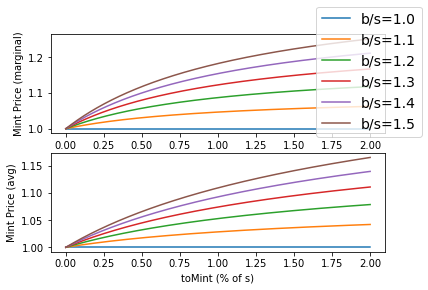

In [13]:
stblSupply = 1000

#range over bufferValue/stblSupply
brange = np.linspace(1,1.5,6)
x = np.linspace(0,2, 1000)
#range over toMint/stblSupply
fig, axs = plt.subplots(2,1)
for b in brange:
    bufferValue = stblSupply*b
    y = [logMintFeeAMM(xx*stblSupply, bufferValue, stblSupply)[0] for xx in x]
    z = [logMintFeeAMM(xx*stblSupply, bufferValue, stblSupply)[1] for xx in x]
    axs[0].plot(x, z)
    axs[1].plot(x, y, label='b/s={}'.format(b))

fig.legend(loc='upper right', fontsize=14)
axs[0].set(xlabel='toMint (% of s)', ylabel='Mint Price (marginal)')
axs[1].set(xlabel='toMint (% of s)', ylabel='Mint Price (avg)')
fig.show()

We can similarly apply a different utiltiy model: exponential utility. This model will tend to a max fee, which would target a maximum buffer size per stablecoin, above which there is little additional benefit (assuming the utility model, at least).

Next, consider redemption AMM mechanics. For designs A and B, these target \$1 redemption with haircuts to every holder when the buffer value per coin is < \$1.

In [14]:
def mmfRedeemAMM(toRedeem, bufferValue, stblSupply):
    Rate = np.min( 1., bufferValue/stblSupply)
    return Rate

For design C, consider different redemption models that tend to the above mechanics in large withdrawals, but aim to maintain the peg in smaller withdrawals. I.e., the system may be undercollateralized at times, but the peg can still be maintained unless there are mass exits or a successful currency attack. The decreased redemption rate for large redemptions aims to protect against currency attacks

consider peg decay curves of the following forms
f(x, y) = 1 - y x^n
f(x, y) = 2 - exp(yx)
where x = toRedeem, and y = variable calibrating the netOutflow
These are examples of decay functions that allow redemptions \~\$1 but rapidly decay for large redemptions. Decay could be floored at NAV - fee (though note that NAV is really a function of x,y as NAV decreases for the smaller level of outflow)

In [15]:
from scipy import optimize

class polyDecay:
    def __init__(self, n):
        self.n = n
    
    def redeemDecay(self, x,y):
        return 1 - y*x**self.n
    
    def cumRedeemDecay(self, x,y):
        return x*(1-y*x**self.n / (self.n+1))
    
    def decayZero(self, y):
        return 1/y**(1/self.n)
    
    def cumDecayZero(self, bufferValue, stblSupply, y):
        def f(x):
            return (bufferValue - self.cumRedeemDecay(x,y))/(stblSupply-x) - self.redeemDecay(x,y)
        
        return optimize.newton(f, self.decayZero(y))

def redeemAMM(toRedeem, bufferValue, stblSupply, histOutflowEMA, decayCurve):
    
    if bufferValue/stblSupply >= 1 or toRedeem == 0:
        return (1,1)
    
    targetOutflow = (outflowParam - histOutflowEMA/stblSupply)*stblSupply
    y = targetOutflow**(-decayCurve.n)
    z = decayCurve.cumDecayZero(bufferValue, stblSupply, y) #max amount to redeem until redeem at the new NAV
    minRedeemPrice = decayCurve.redeemDecay(z,y)
    if minRedeemPrice < bufferValue/stblSupply*maxNavDecay:
        return (bufferValue/stblSupply, bufferValue/stblSupply)
    
    #marginal price is np.max(decayCurve.redeemDecay(toRedeem,y), minRedeemPrice)
    if toRedeem <= z:
        return (decayCurve.cumRedeemDecay(toRedeem,y) / toRedeem , decayCurve.redeemDecay(toRedeem, y))
    else:
        return ( (decayCurve.cumRedeemDecay(z,y) + minRedeemPrice*(toRedeem - z)) / toRedeem , minRedeemPrice )

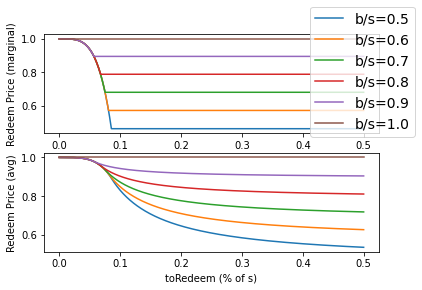

In [16]:
poly4Decay = polyDecay(4)
outflowParam = 0.1
histOutflowEMA = 0
maxNavDecay = 0.1

#range over bufferValue/stblSupply
brange = np.linspace(0.5,1,6)
x = np.linspace(0,0.5, 1000)

fig, axs = plt.subplots(2,1)
for b in brange:
    bufferValue = stblSupply*b
    yy = [redeemAMM(xx*stblSupply, bufferValue, stblSupply, histOutflowEMA, poly4Decay)[0] for xx in x]
    zz = [redeemAMM(xx*stblSupply, bufferValue, stblSupply, histOutflowEMA, poly4Decay)[1] for xx in x]
    axs[0].plot(x, zz)
    axs[1].plot(x, yy, label='b/s={}'.format(b))

fig.legend(loc='upper right', fontsize=14)
axs[0].set(xlabel='toRedeem (% of s)', ylabel='Redeem Price (marginal)')
axs[1].set(xlabel='toRedeem (% of s)', ylabel='Redeem Price (avg)')
fig.show()